In [ ]:
###########################################################################################################
#Modeling with Tensorflow code
#----------------------------------------------------------------------------------------------------------
#https://github.com/probcomp/gen-quickstart/blob/master/tutorials/Modeling%20with%20TensorFlow%20Code.ipynb
###########################################################################################################

In [1]:
#Gen can call Tensorflow code from Python
using Gen
using PyPlot
using GenTF
using PyCall

println(PyCall.python)

/home/jberez/.julia/conda/3/bin/python


In [2]:
tf = pyimport("tensorflow")
nn = tf.nn

PyObject <module 'tensorflow._api.v2.nn' from '/home/jberez/.julia/conda/3/lib/python3.7/site-packages/tensorflow/_api/v2/nn/__init__.py'>

In [3]:
#Input placeholder for MNIST Images
xs = tf.compat.v1.placeholder(tf.float64, shape=(nothing, 784))

#Weight matrix parameter for softmax classifier initialized to a zero matrix
init_W = zeros(Float64, 784, 10)
W = tf.compat.v1.Variable(init_W)

#Bias vector parameter initialized to zeros
init_b = zeros(Float64, 10)
b = tf.compat.v1.Variable(init_b)

#Softmax "Probabilities" for each class
probs = nn.softmax(tf.add(tf.matmul(xs, W), b), axis=1)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


PyObject <tf.Tensor 'Softmax:0' shape=(None, 10) dtype=float64>

In [9]:
#Create a new TF session for executing generative function
tf_softmax_model = TFFunction([W,b], [xs], probs)

2020-07-17 10:04:10.399501: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2020-07-17 10:04:10.429384: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 2499950000 Hz
2020-07-17 10:04:10.429937: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x6022260 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2020-07-17 10:04:10.429975: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2020-07-17 10:04:10.430123: I tensorflow/core/common_runtime/process_util.cc:147] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


TFFunction(PyObject <tensorflow.python.client.session.Session object at 0x7facff28df50>, PyObject[PyObject <tf.Tensor 'Placeholder_1:0' shape=(None, 784) dtype=float64>], PyObject <tf.Tensor 'Softmax:0' shape=(None, 10) dtype=float64>, Dict{PyObject,PyObject}(PyObject <tf.Variable 'Variable_1:0' shape=(10,) dtype=float64> => PyObject <tf.Variable 'Variable_3:0' shape=(10,) dtype=float64>,PyObject <tf.Variable 'Variable:0' shape=(784, 10) dtype=float64> => PyObject <tf.Variable 'Variable_2:0' shape=(784, 10) dtype=float64>), PyObject[PyObject <tf.Tensor 'gradients/MatMul_grad/MatMul:0' shape=(None, 784) dtype=float64>], PyObject <tf.Tensor 'Placeholder_2:0' shape=<unknown> dtype=float64>, PyObject <tf.Operation 'group_deps' type=NoOp>, PyObject <tf.Operation 'group_deps_1' type=NoOp>, PyObject <tf.Tensor 'Placeholder_3:0' shape=() dtype=float64>)

In [19]:
#Run on fake data
fake_xs = rand(5, 784)
probs = tf_softmax_model(fake_xs)
println(size(probs))
println(probs)

#The return value corresponds to the labels as determined by the model (I think)
(trace, _) = Gen.generate(tf_softmax_model, (fake_xs,))
Gen.get_choices(trace)
println(size(Gen.get_retval(trace)))
println(Gen.get_retval(trace))

(5, 10)
[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1; 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1; 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1; 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1; 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
(5, 10)
[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1; 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1; 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1; 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1; 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


In [20]:
#Create a function to sample a categorical variable based on the model "probabilities"
@gen function digit_model(xs::Matrix{Float64})
    
    # there are N input images, each with D pixels
    (N, D) = size(xs)
    
    # invoke the `net` generative function to compute the digit label probabilities for all input images
    probs = @trace(tf_softmax_model(xs), :softmax)
    @assert size(probs) == (N, 10)
    
    # sample a digit label for each of the N input images
    for i=1:N
        @trace(categorical(probs[i,:]), (:y, i)) 
    end
end;

In [23]:
#Obtain a trace of the model
(trace, _) = Gen.generate(digit_model, (fake_xs,));

#Here we have the classification results for a single trace
display(Gen.get_choices(trace))

│
├── (:y, 1) : 2
│
├── (:y, 5) : 6
│
├── (:y, 2) : 5
│
├── (:y, 4) : 6
│
├── (:y, 3) : 3
│
└── :softmax


In [4]:
#Load MNIST (calls MLDatasets)
include("mnist.jl")
training_data_loader = MNISTTrainDataLoader();

In [27]:
update = Gen.ParamUpdate(Gen.FixedStepGradientDescent(0.00001), tf_softmax_model => [W,b])

ParamUpdate(Dict{GenerativeFunction,Any}(TFFunction(PyObject <tensorflow.python.client.session.Session object at 0x7facff28df50>, PyObject[PyObject <tf.Tensor 'Placeholder_1:0' shape=(None, 784) dtype=float64>], PyObject <tf.Tensor 'Softmax:0' shape=(None, 10) dtype=float64>, Dict{PyObject,PyObject}(PyObject <tf.Variable 'Variable_1:0' shape=(10,) dtype=float64> => PyObject <tf.Variable 'Variable_3:0' shape=(10,) dtype=float64>,PyObject <tf.Variable 'Variable:0' shape=(784, 10) dtype=float64> => PyObject <tf.Variable 'Variable_2:0' shape=(784, 10) dtype=float64>), PyObject[PyObject <tf.Tensor 'gradients/MatMul_grad/MatMul:0' shape=(None, 784) dtype=float64>], PyObject <tf.Tensor 'Placeholder_2:0' shape=<unknown> dtype=float64>, PyObject <tf.Operation 'group_deps' type=NoOp>, PyObject <tf.Operation 'group_deps_1' type=NoOp>, PyObject <tf.Tensor 'Placeholder_3:0' shape=() dtype=float64>) => GenTF.FixedStepGradientDescentTFFunctionState(PyObject <tf.Operation 'GradientDescent' type=NoOp>,

In [29]:
#Obtain MNIST Batch. Data generator returns a tuple
function data_generator()
    (xs, ys) = next_batch(training_data_loader, 100)

    @assert size(xs) == (100, 784)
    @assert size(ys) == (100,)
    constraints = Gen.choicemap()
    for (i, y) in enumerate(ys)
        constraints[(:y, i)] = y
    end
    ((xs,), constraints)
end;

@time scores = Gen.train!(digit_model, data_generator, update;
    num_epoch=10000, epoch_size=1, num_minibatch=1, minibatch_size=1, verbose=false);

 79.165847 seconds (94.29 M allocations: 29.663 GiB, 2.03% gc time)


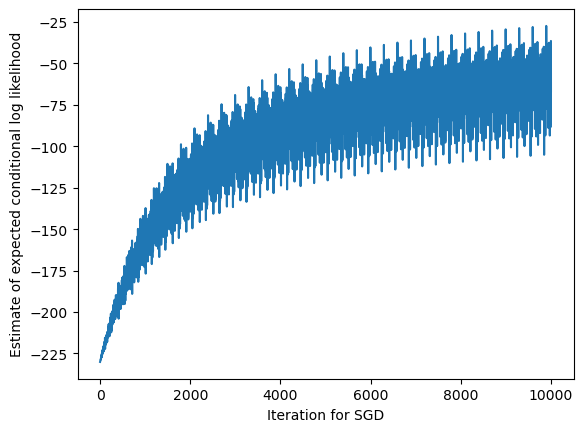

PyObject Text(24.000000000000014, 0.5, 'Estimate of expected conditional log likelihood')

In [30]:
#Now plot the scores over time
plot(scores)
xlabel("Iteration for SGD")
ylabel("Estimate of expected conditional log likelihood")

In [5]:
#Exercise: compare to running one image at a time
x = tf.compat.v1.placeholder(tf.float64, shape=(784,))
W_unvec = tf.compat.v1.Variable(init_W)
b_unvec = tf.compat.v1.Variable(init_b)
probs_unvec = tf.squeeze(nn.softmax(tf.add(tf.matmul(tf.expand_dims(x,axis=0),W_unvec),b_unvec),axis=1),axis=0)

PyObject <tf.Tensor 'Squeeze:0' shape=(10,) dtype=float64>

In [6]:
tf_softmax_model_single = TFFunction([W_unvec, b_unvec], [x], probs_unvec);
update_unvec = Gen.ParamUpdate(Gen.FixedStepGradientDescent(0.00001), tf_softmax_model_single => [W_unvec, b_unvec]);

2020-07-17 10:40:26.081526: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2020-07-17 10:40:26.098047: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 2499950000 Hz
2020-07-17 10:40:26.098331: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x82386e0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2020-07-17 10:40:26.098346: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2020-07-17 10:40:26.098443: I tensorflow/core/common_runtime/process_util.cc:147] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [19]:
@gen function digit_model_single_image(x::Vector{Float64})
    
    # number of pixels in the image
    D = length(x)
    
    # invoke the `net` generative function to compute the digit label probabilities for all input images
    probs2 = @trace(tf_softmax_model_single(x), :softmax_single2)
    @assert size(probs2) == (10,)
    
    # sample the digit label for the image
    @trace(categorical(probs2), :y)
    
    return nothing
end;

@gen function digit_model_unvectorized(xs::Matrix{Float64})
    (N, D) = size(xs)
    for i=1:N
        digit_model_single_image(xs[i,:])
    end
    
    return nothing
end;

function data_generator_unvectorized()
    (xs, ys) = next_batch(training_data_loader, 100)

    @assert size(xs) == (100, 784)
    @assert size(ys) == (100,)
    constraints = Gen.choicemap()
    for (i, y) in enumerate(ys)
        constraints[(:y, i)] = y
    end
    ((xs,), constraints)
end;

@time scores_unvec = Gen.train!(digit_model_unvectorized, data_generator_unvectorized, update_unvec;
    num_epoch=10, epoch_size=1, num_minibatch=1, minibatch_size=1, verbose=false);

  2.327766 seconds (495.75 k allocations: 61.071 MiB, 0.86% gc time)


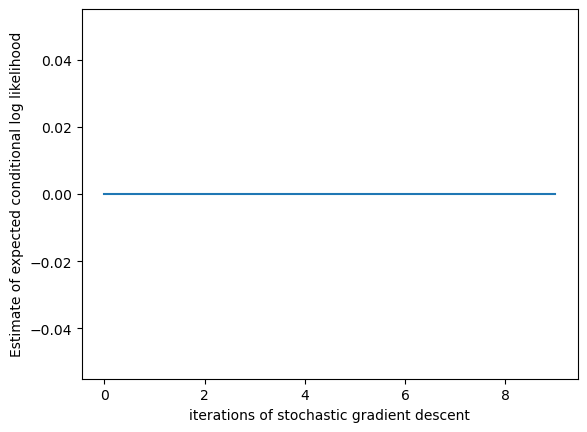

In [20]:
plot(scores_unvec)
xlabel("iterations of stochastic gradient descent")
ylabel("Estimate of expected conditional log likelihood");